In [1]:
import os

import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (5,5)
import seaborn as sns

In [2]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import scvi
import muon as mu
from muon import atac as ac

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0


In [3]:
def assign_lib_from_index(adata, sample_key = 'sample', csv_path = '../../../data/AGG/outs/aggr.csv'):
    aggr = pd.read_csv('../../../data/AGG/outs/aggr.csv')
    lib_idx = [int(index.split('-')[-1]) for index in adata.obs.index.tolist()]
    adata.obs['sample'] = [aggr.iloc[int(n-1)]['library_id'] for n in lib_idx]
    return adata
def assign_lib_from_index_df(df, sample_key = 'sample', csv_path = '../../../data/AGG/outs/aggr.csv'):
    aggr = pd.read_csv('../../../data/AGG/outs/aggr.csv')
    lib_idx = [int(index.split('-')[-1]) for index in df.index.tolist()]
    df['sample'] = [aggr.iloc[int(n-1)]['library_id'] for n in lib_idx]
    return df

In [ ]:
atac = mu.read(f'objects/atac.h5ad')
atac

AnnData object with n_obs × n_vars = 115045 × 152291
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
ac.tl.locate_file(atac, key ='fragments', file = f'../../../data/AGG/outs/atac_fragments.tsv.gz')
atac

AnnData object with n_obs × n_vars = 115045 × 152291
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files'

In [6]:
ac.tl.add_peak_annotation(atac, annotation="~/Documents/CZI/MULTIOME/data/AGG/outs/atac_peak_annotation.tsv")

In [7]:
atac = assign_lib_from_index(atac)

In [8]:
sample_color_dic = {'lib_09': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'lib_10': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'lib_15': (1.0, 0.4980392156862745, 0.054901960784313725),
 'lib_23': (1.0, 0.7333333333333333, 0.47058823529411764),
 'lib_29': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'lib_34': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'lib_36': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'lib_38': (1.0, 0.596078431372549, 0.5882352941176471),
 'lib_51': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'lib_54': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'lib_55': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'lib_56': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'lib_57': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

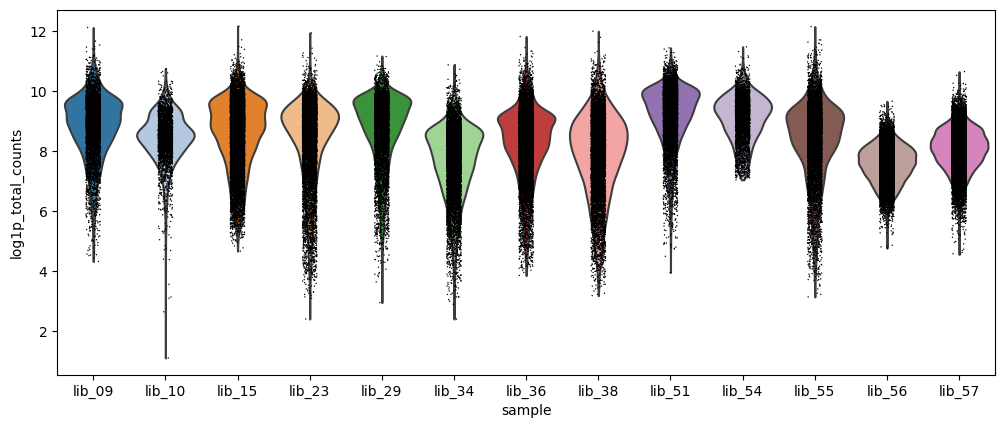

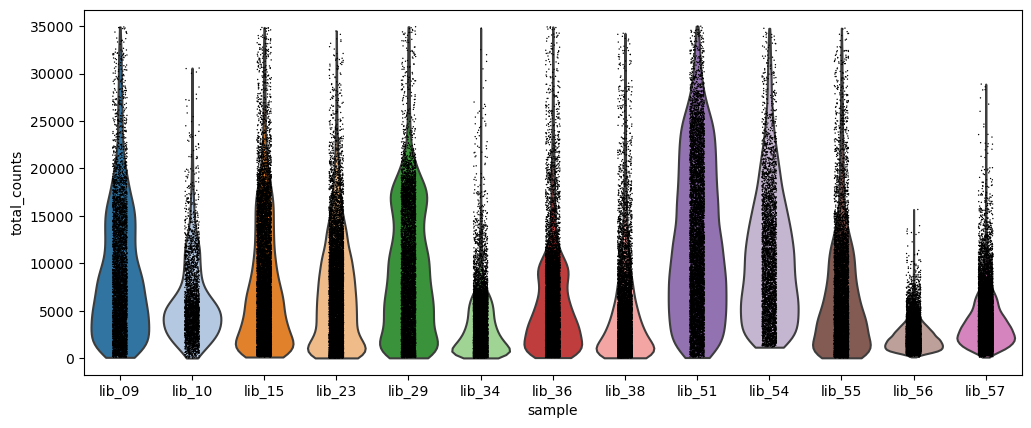

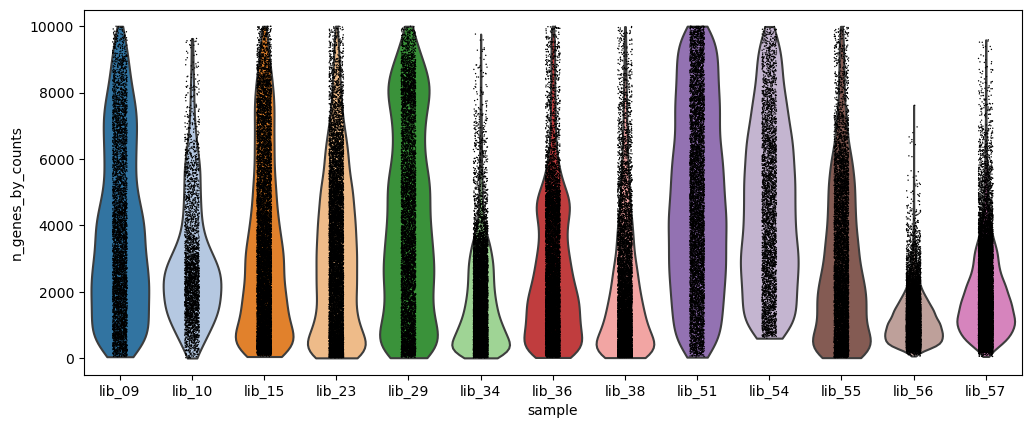

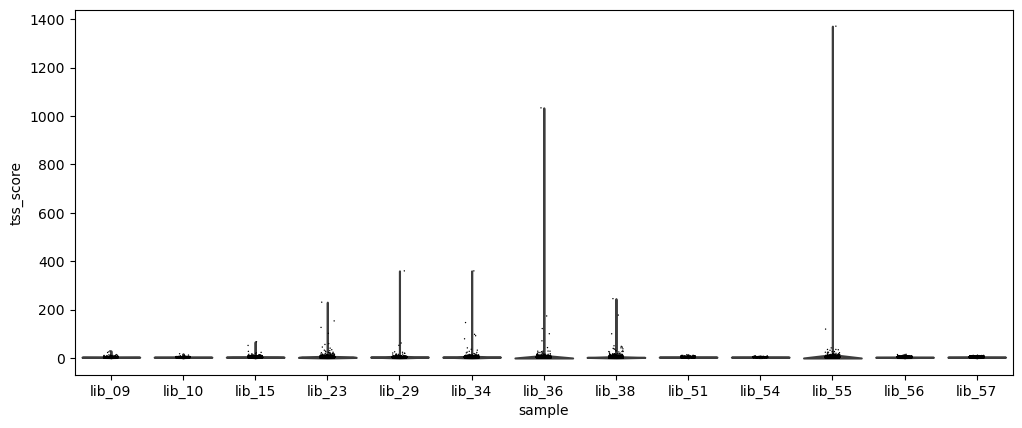

In [11]:
rcParams['figure.figsize'] = (10,5)
sc.pl.violin(atac, ['log1p_total_counts'], ncol= 1, jitter=0.1, multi_panel=True, groupby= 'sample', palette=sample_color_dic)
sc.pl.violin(atac[atac.obs['total_counts']<35000], ['total_counts'], ncol= 1, jitter=0.1, multi_panel=True, groupby= 'sample', palette=sample_color_dic)
sc.pl.violin(atac[atac.obs['n_genes_by_counts']<10000], ['n_genes_by_counts'], ncol= 1, jitter=0.1, multi_panel=True, groupby= 'sample', palette=sample_color_dic)
sc.pl.violin(atac, ['tss_score'], ncol= 1, jitter=0.1, multi_panel=True, groupby= 'sample', vmax = 'p99', palette=sample_color_dic)

# Apply QC cutoffs

In [9]:
atac

AnnData object with n_obs × n_vars = 115045 × 152291
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'files', 'atac', 'sample_colors'

In [10]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: x >= 200)
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 2500) & (x <= 30000))

In [11]:
atac = atac[atac.obs['nucleosome_signal']<4].copy()
atac = atac[atac.obs['tss_score']>2].copy()

In [12]:
df = pd.DataFrame(atac.obs['sample'].value_counts().index, index = atac.obs['sample'].value_counts().index  , columns =[ 'samples' ])
df['n_cells'] = atac.obs['sample'].value_counts().values.astype(int)

<AxesSubplot:title={'center':'Total nº of Cells'}, xlabel='samples'>

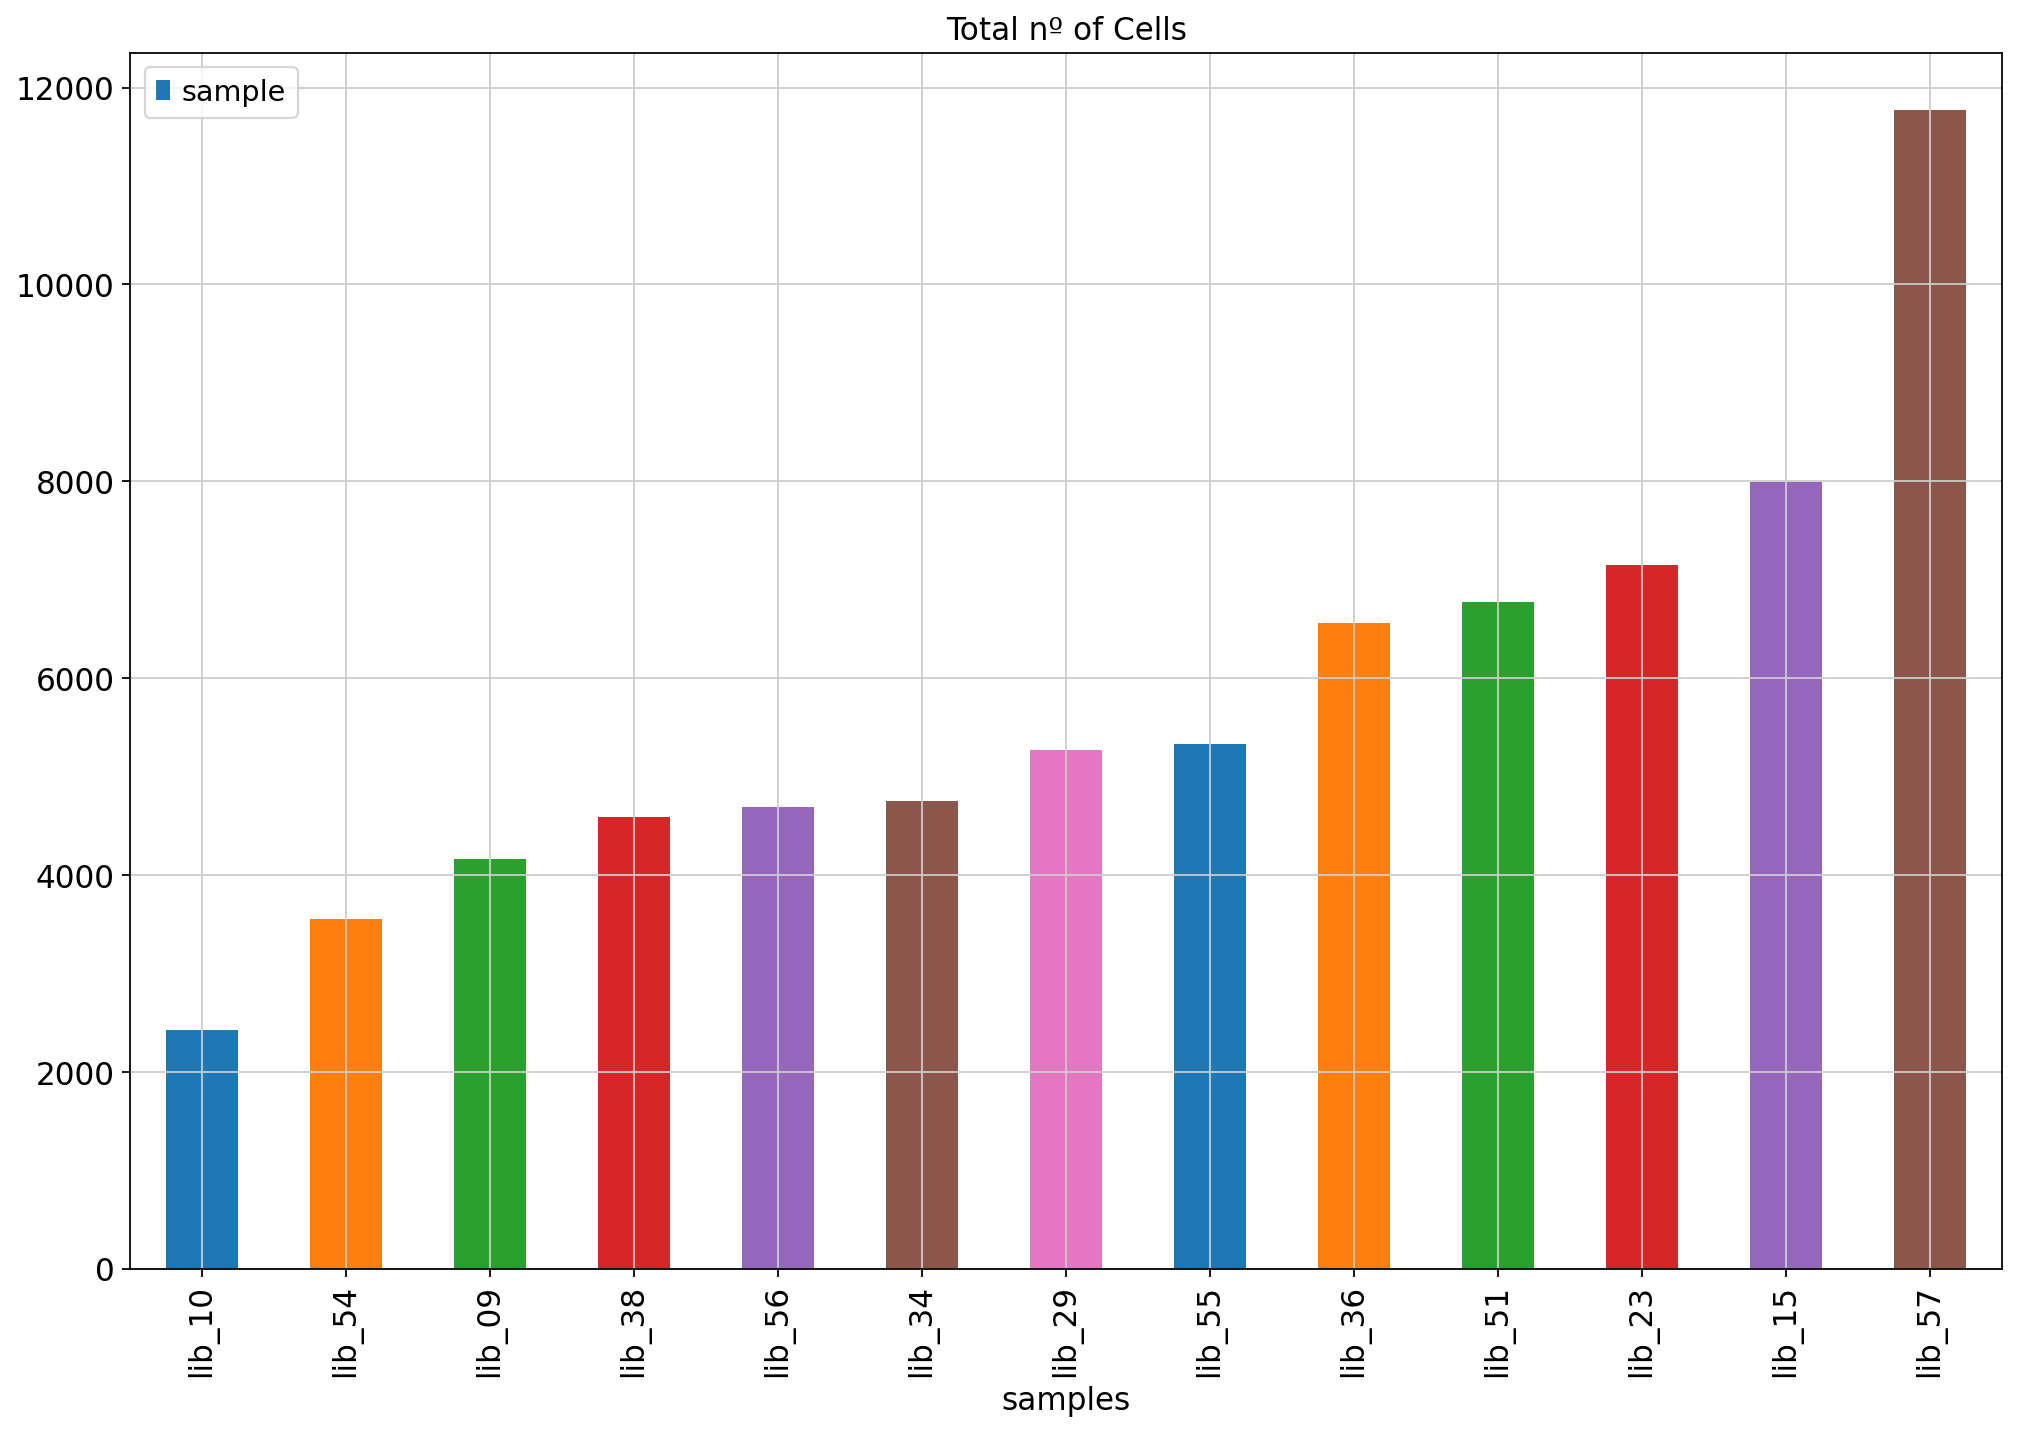

In [13]:
sc.settings.set_figure_params(figsize=('15', '10'), color_map='gist_earth')
df.reindex(index=np.argsort(df['n_cells']).index.tolist()[::-1]).plot(kind='bar', x = 'samples', y ='n_cells', label ='sample', color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'], title = 'Total nº of Cells' )

In [14]:
atac.layers['counts'] = atac.X.copy()

## Normalization

In [15]:
ac.pp.tfidf(atac, scale_factor=1e4)

## Dim Rde

In [16]:
atac.uns['sample_colors'] = np.array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8'], dtype=object)

In [17]:
ac.tl.lsi(atac)

In [18]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [19]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [20]:
sc.tl.leiden(atac, resolution=.55)

In [21]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

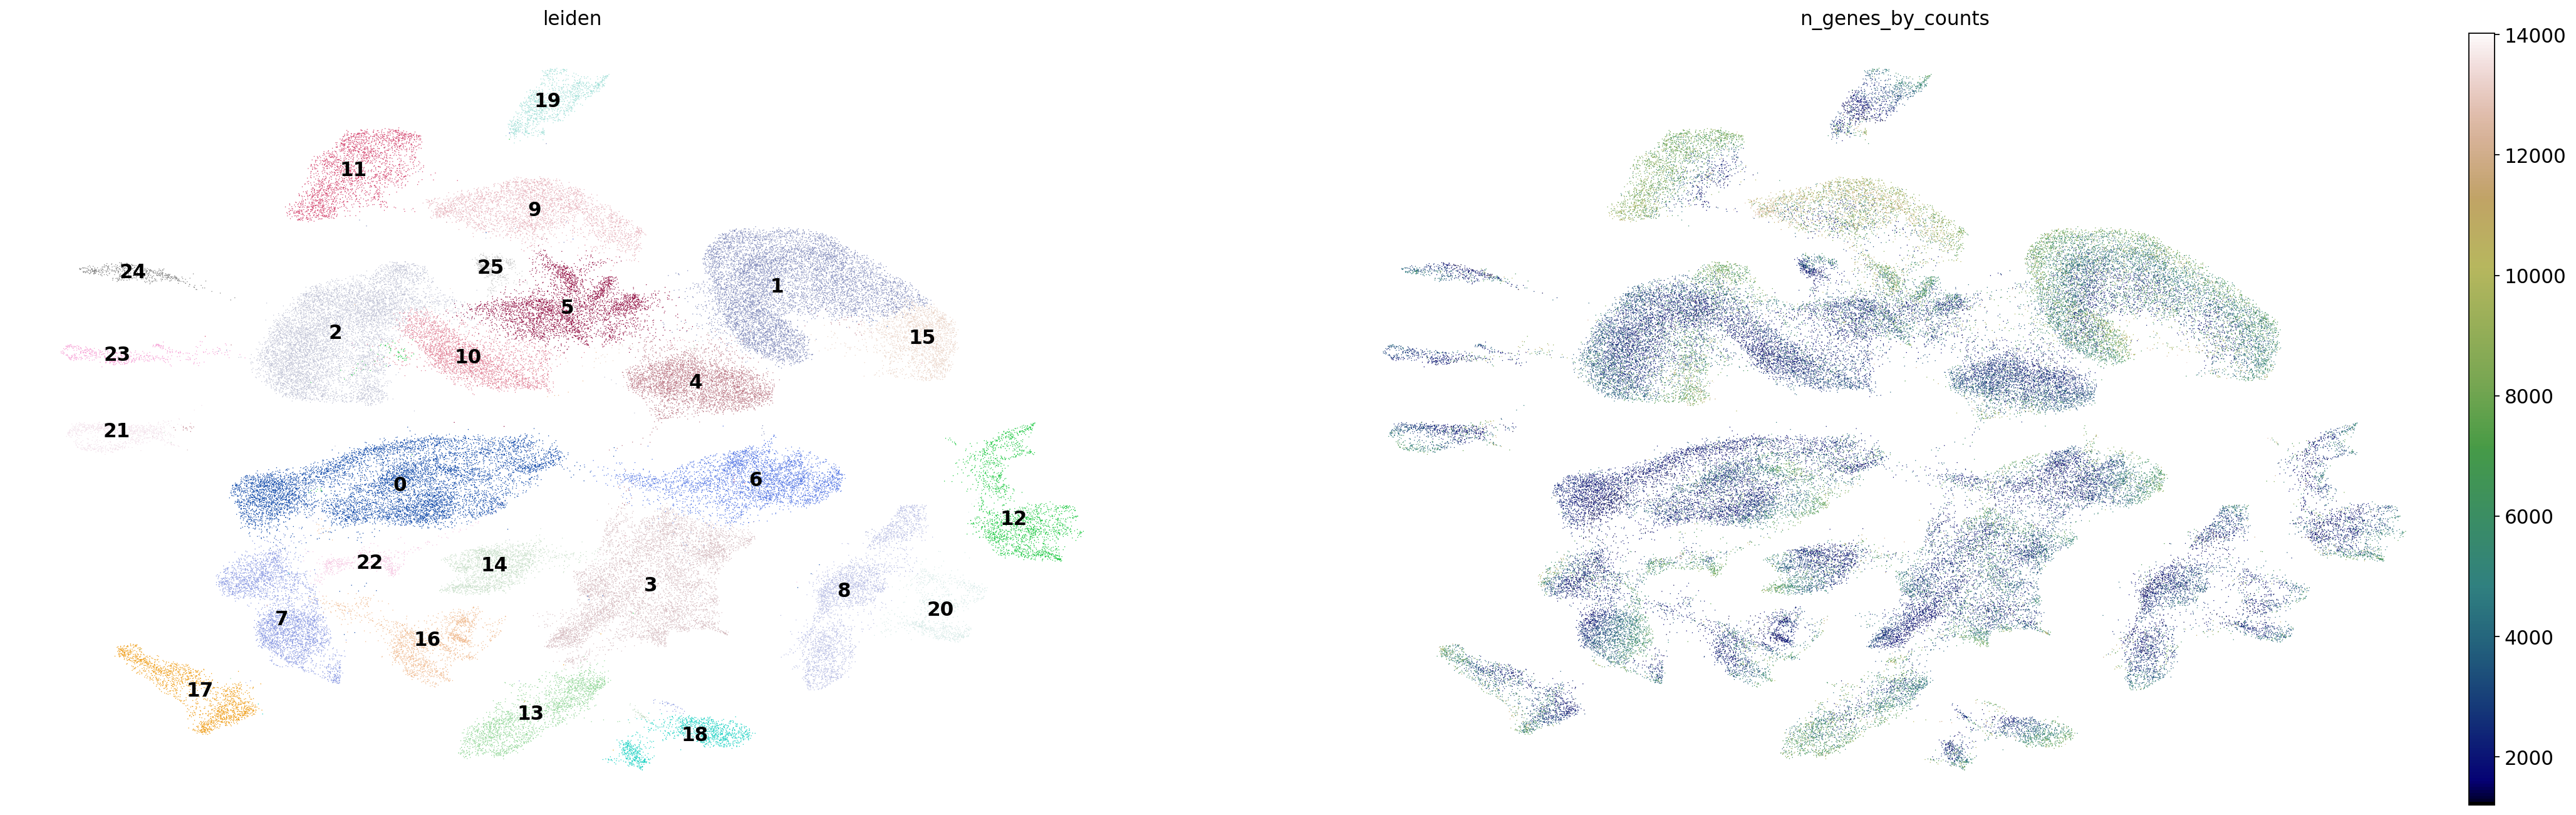

In [22]:
sc.pl.umap(atac, color=["leiden","n_genes_by_counts"], legend_loc="on data", frameon = False)

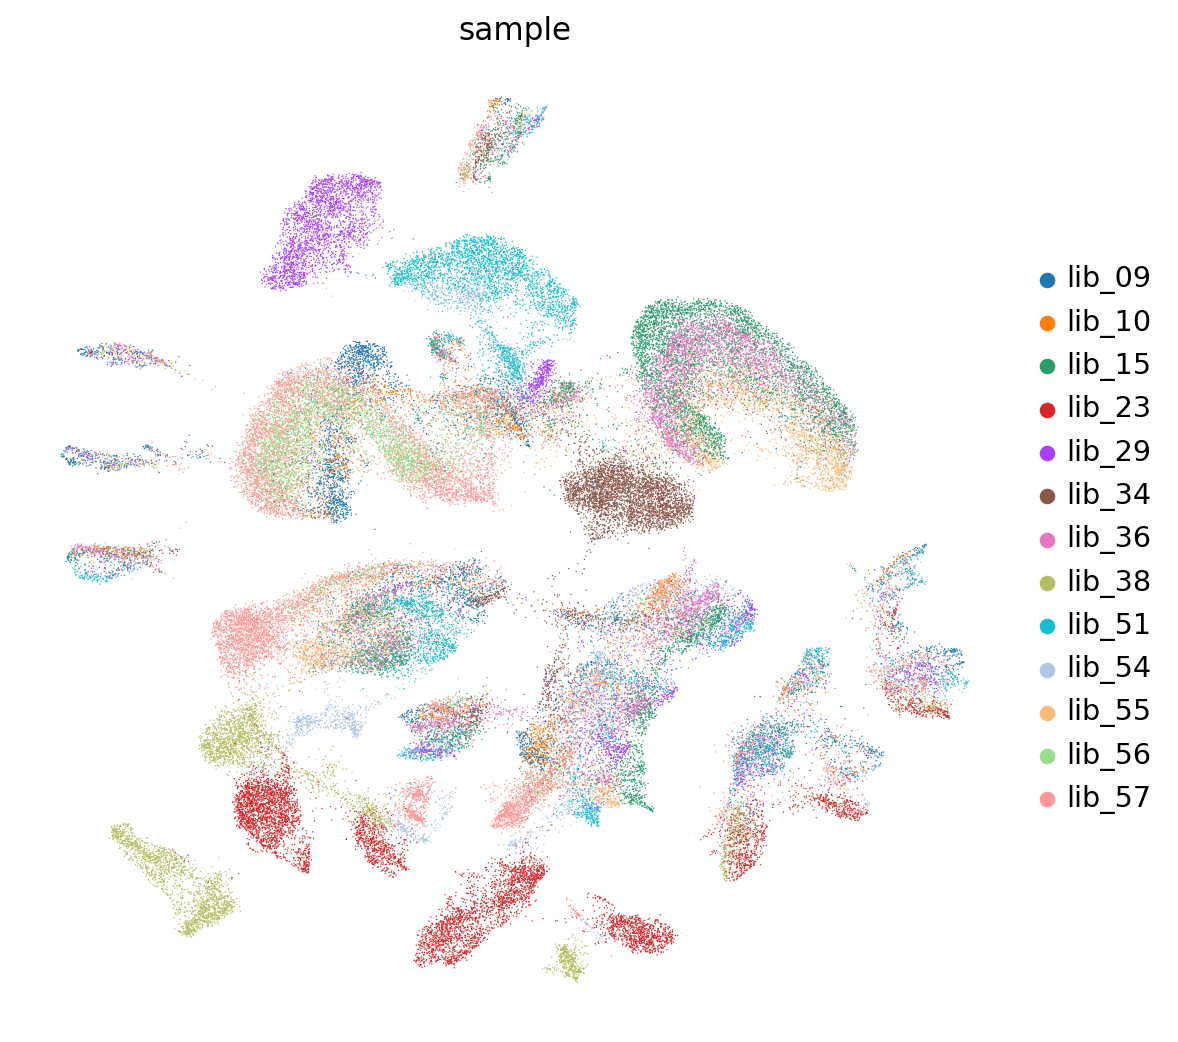

In [23]:
rcParams['figure.figsize'] = (8,8)
sc.pl.umap(atac, color=["sample"], frameon = False)

## Clust w/out Batch Effect

In [24]:
import harmonypy as hm
ho = hm.run_harmony(atac.obsm['X_lsi'], atac.obs, 'sample')


2023-04-03 21:46:18,826 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-03 21:46:26,589 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-03 21:46:26,941 - harmonypy - INFO - Iteration 1 of 10
2023-04-03 21:46:51,918 - harmonypy - INFO - Iteration 2 of 10
2023-04-03 21:47:16,980 - harmonypy - INFO - Converged after 2 iterations


In [25]:
harmonized = pd.DataFrame(ho.Z_corr.T, index = atac.obs.index)
harmonized.head(1)

0         1         2         3        4         5   \
AAACAGCCAACACCTA-3 -1.153008 -0.170646  0.139526 -0.487442 -0.03555 -1.273153   

                          6         7         8         9   ...        39  \
AAACAGCCAACACCTA-3 -0.760249  0.456717  0.260453 -0.051301  ...  0.101596   

                          40        41       42        43        44        45  \
AAACAGCCAACACCTA-3  0.010825 -0.161952 -0.30666  0.533312 -0.551632 -0.449878   

                          46        47        48  
AAACAGCCAACACCTA-3  0.191274 -0.232054 -0.571829  

[1 rows x 49 columns]

In [26]:
# Write the adjusted PCs to a new file.
atac.obsm['X_lsi_harmonized'] = harmonized.values
atac.obsm['X_lsi_harmonized'] 

array([[-1.1530081 , -0.17064573,  0.13952626, ...,  0.19127388,
        -0.23205354, -0.57182894],
       [-1.29674971, -0.17007313,  0.08528833, ..., -0.31462671,
        -1.33092662,  0.3503385 ],
       [-1.4764722 ,  0.20045596, -0.07353253, ..., -0.25452755,
         0.22333726, -0.41123251],
       ...,
       [-0.01391791,  0.17824054,  1.0971699 , ...,  0.80777538,
         1.67865011, -0.66998481],
       [ 0.75953483, -0.75599868, -1.50367265, ...,  1.29737225,
         0.47221359,  0.38534578],
       [-1.42083197, -0.09237344,  0.12734938, ...,  0.61253229,
        -0.19381999, -0.80380564]])

In [27]:
sc.pp.neighbors(atac, use_rep="X_lsi_harmonized", n_neighbors=10, n_pcs=30)

In [28]:
sc.tl.leiden(atac, resolution=.65)

In [29]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

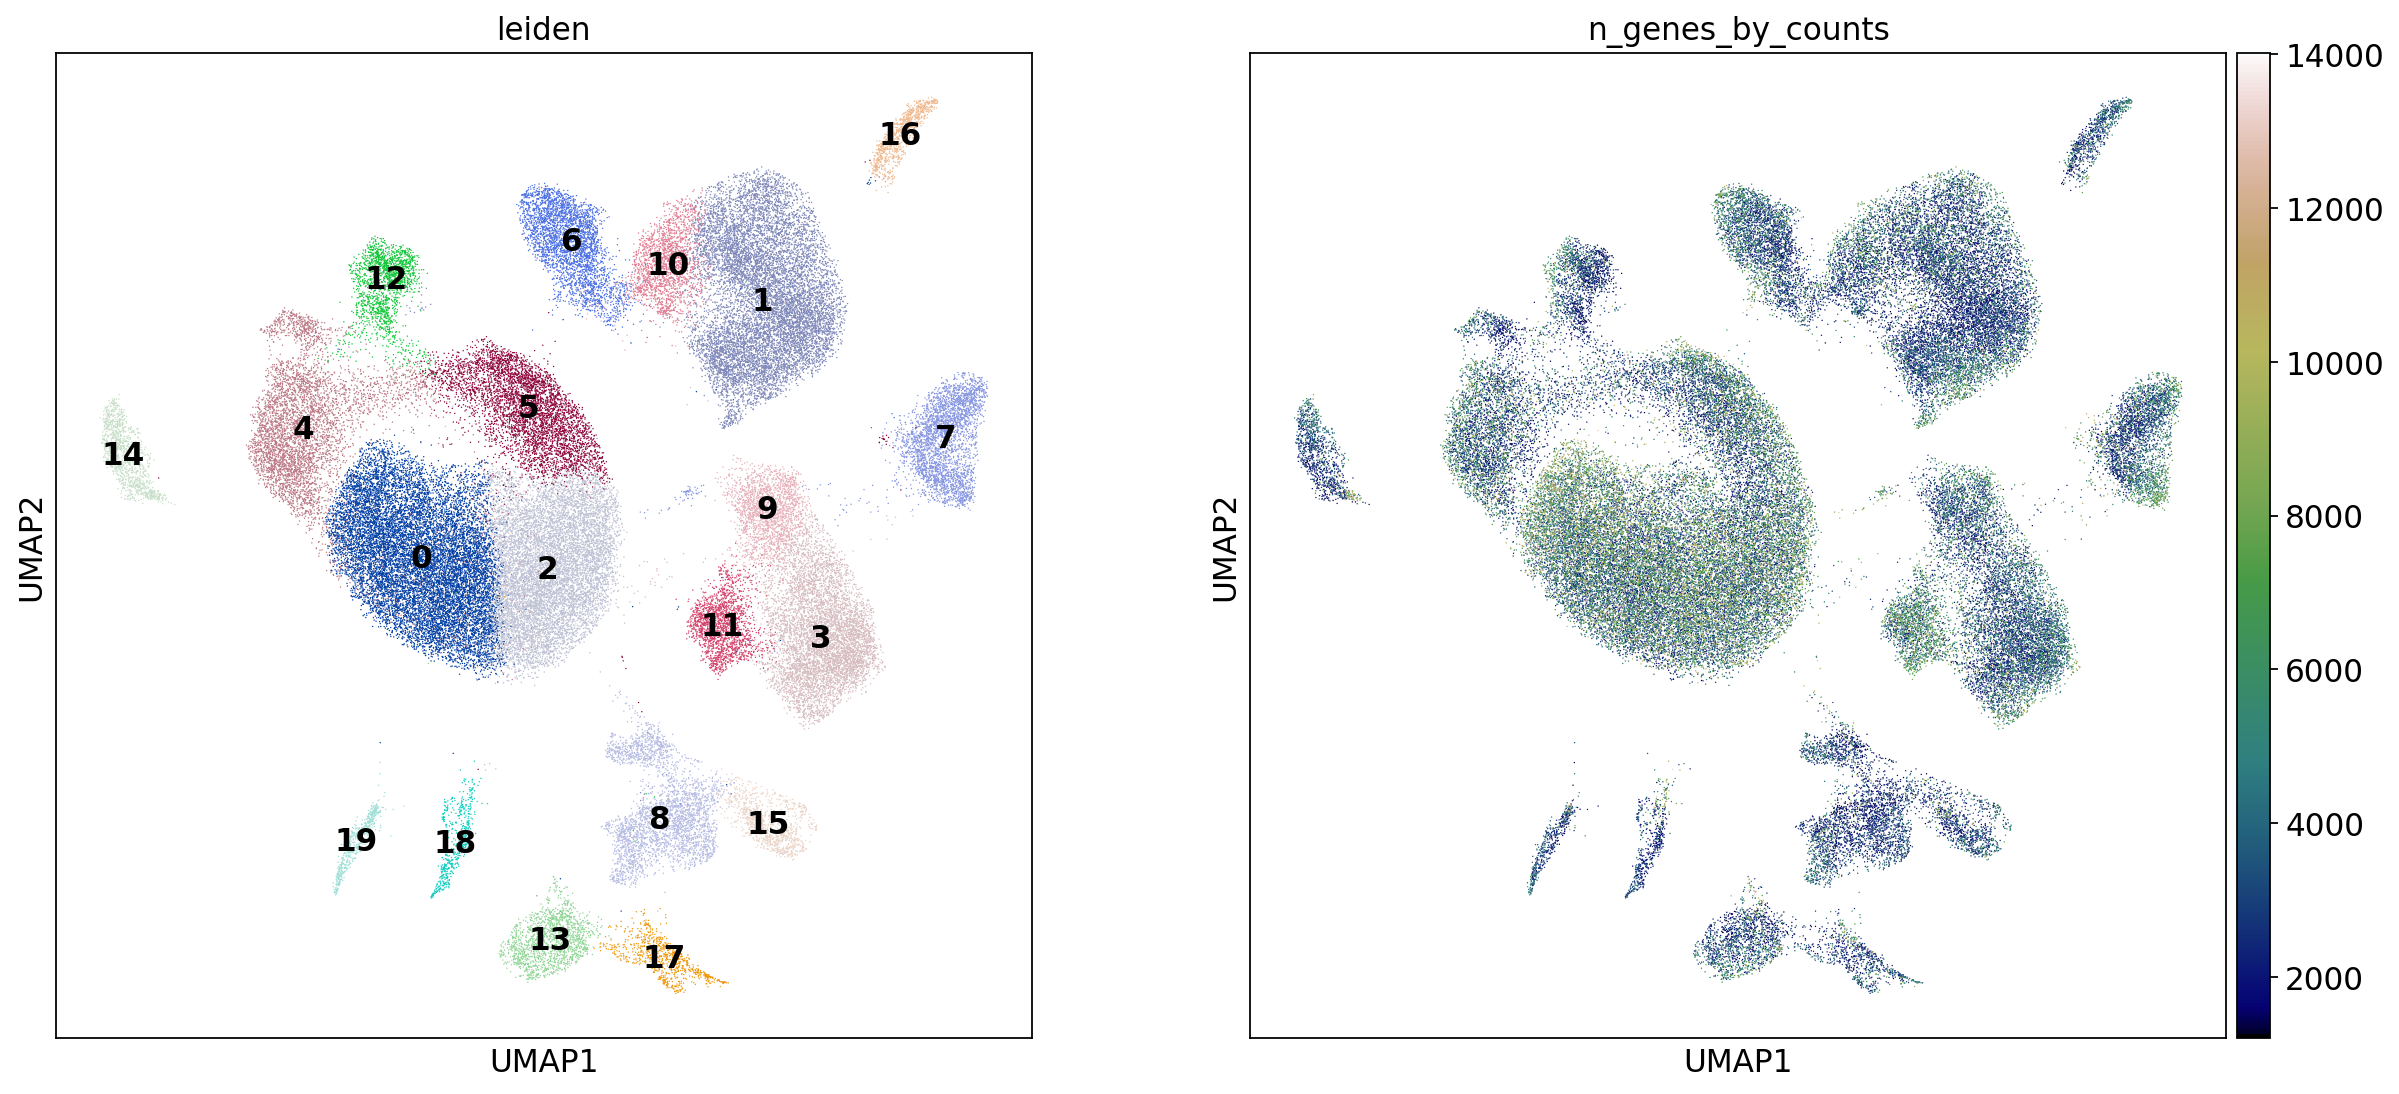

In [30]:
sc.pl.umap(atac, color=["leiden","n_genes_by_counts"], legend_loc="on data")

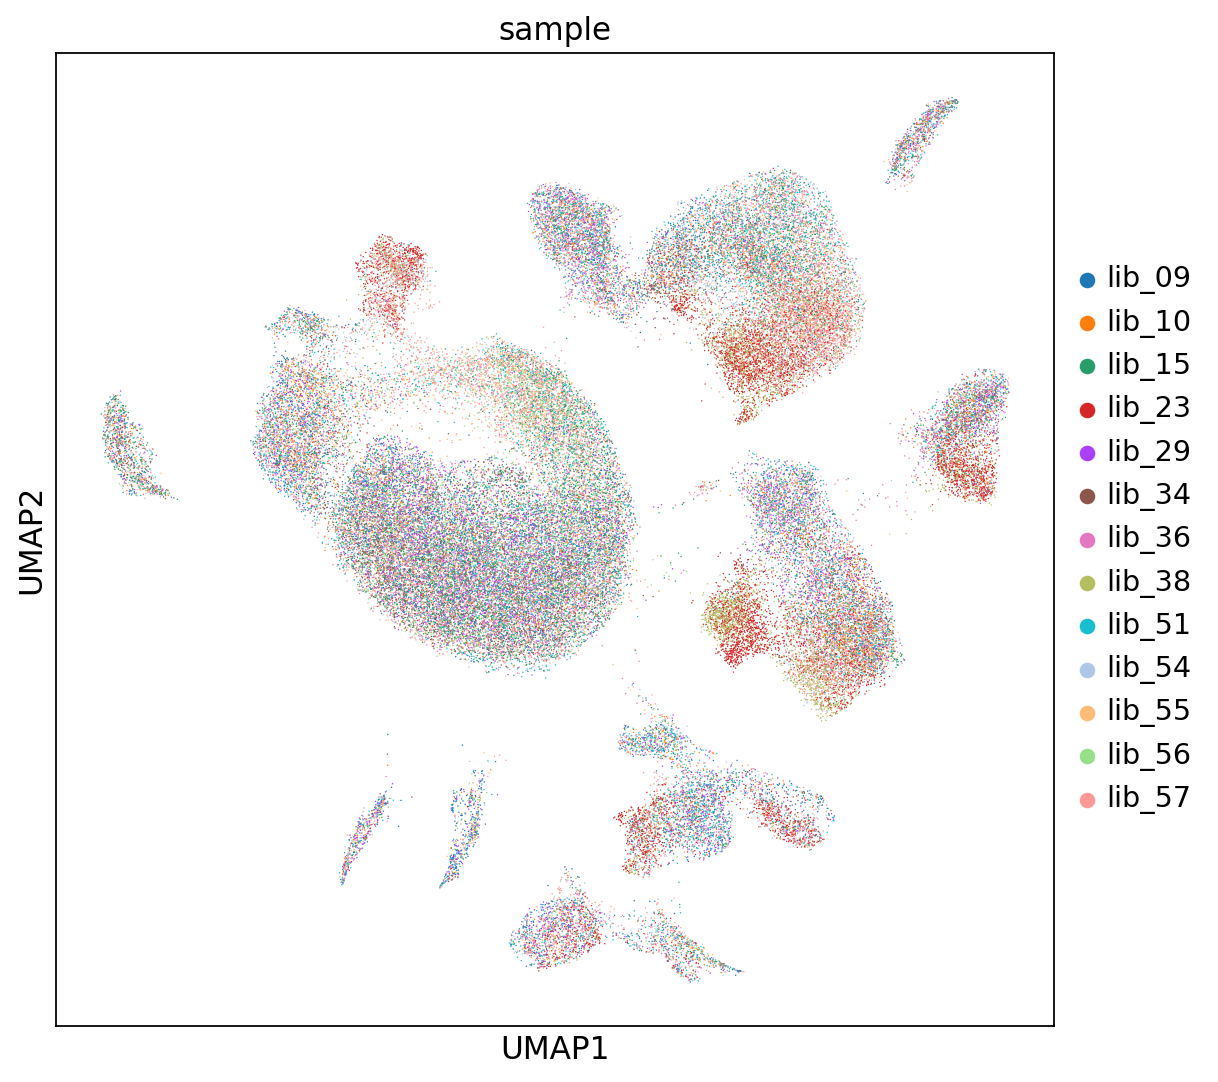

In [31]:
sc.pl.umap(atac, color=["sample"])

## Markers

In [32]:
ac.tl.add_peak_annotation(atac, annotation="~/Documents/CZI/MULTIOME/data/AGG/outs/atac_peak_annotation.tsv")

In [33]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [34]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
# pd.set_option("max_columns", 50)
dict_={}
markers = pd.DataFrame({group + '_' + key[:1]: result[key][group][0:2000]
    for group in groups for key in ['names', 'genes', 'pvals']})  

In [35]:
markers.head(10)

0_n         0_g  0_p                       1_n  \
0   chr5:151028554-151029329        GPX3  0.0   chr15:57540864-57541762   
1    chr17:64920458-64921311    LRRC37A3  0.0      chr5:4480674-4481611   
2    chr10:52965241-52966116  AC073174.1  0.0      chr5:2751378-2752288   
3    chr13:72851094-72852013       PIBF1  0.0  chr1:168755706-168756578   
4    chr14:94598949-94599886  AL049839.3  0.0   chr14:25833174-25834070   
5  chr10:106957964-106958860      SORCS1  0.0  chr1:160061318-160062196   
6     chr2:88178980-88179874      THNSL2  0.0      chr9:2427109-2428012   
7    chr10:86164025-86164790       GRID1  0.0      chr4:2071795-2072652   
8   chr8:144502815-144503716         GPT  0.0   chr21:33983880-33984777   
9     chr9:92242064-92242990        IARS  0.0        chr5:533481-534352   

                      1_g            1_p                       2_n  \
0       CGNL1, AC025271.2   0.000000e+00  chr8:144502815-144503716   
1  AC106799.1, AC106799.2   0.000000e+00   chr13:72851094-72852013   
2           C5orf38, IRX2   0.000000e+00   chr22:24494740-24495620   
3              AL031275.1   0.000000e+00    chr4:71338485-71339382   
4   AL132633.1, LINC02306   0.000000e+00  chr3:155079599-155080506   
5      AL121987.1, KCNJ10   0.000000e+00   chr16:56667748-56668656   
6   VLDLR-AS1, AL353614.1  4.368983e-309   chr20:38355037-38355946   
7             NAT8L, POLN  2.865741e-307   chr21:27777037-27777930   
8               LINC00649  2.745575e-304       chr11:409449-410383   
9                  SLC9A3  1.522282e-300  chr2:127137682-127138601   

                 2_g            2_p                       3_n  ...  \
0                GPT  9.285184e-299   chr12:49950144-49951073  ...   
1              PIBF1  3.197704e-275   chr12:49868858-49869774  ...   
2  UPB1, ADORA2A-AS1  3.288013e-246  chr3:128434855-128435730  ...   
3             SLC4A4  1.029263e-242   chr17:10791860-10792767  ...   
4                MME  3.162561e-241   chr11:19441924-19442836  ...   
5               MT1G  1.570495e-237   chr19:14475081-14476009  ...   
6                LBP  1.758111e-234    chr2:28610433-28611309  ...   
7          LINC00113  8.161312e-231   chr19:14479605-14480533  ...   
8             SIGIRR  4.089670e-225    chr8:38938283-38938984  ...   
9         AC110926.2  3.539011e-224   chr12:12890890-12891699  ...   

           16_p                      17_n               17_g          17_p  \
0  3.930388e-51  chr5:150144234-150145083             PDGFRB  4.323770e-45   
1  4.756609e-43    chr1:39625191-39626116   HEYL, AL035404.2  9.331854e-40   
2  8.140280e-39   chr13:41547118-41548006               RGCC  9.894556e-38   
3  5.661968e-37  chr7:139734170-139735002              HIPK2  3.363288e-33   
4  1.945872e-35   chr17:40542238-40543132               CCR7  3.496034e-32   
5  1.789944e-34  chr2:240250999-240251910         AC124861.1  5.479661e-32   
6  3.287951e-34  chr2:240259248-240260162         AC124861.1  1.203840e-31   
7  3.377299e-34  chr9:127862048-127862938                ENG  8.605418e-31   
8  9.154762e-34   chr22:38069169-38070038  PICK1, AL031587.2  9.955148e-31   
9  1.101065e-32    chr2:98162406-98163317              VWA3B  1.264717e-30   

                        18_n                  18_g          18_p  \
0     chr2:43131049-43131942            AC010883.2  7.029209e-39   
1   chr7:142808583-142809450                TRBV30  3.004623e-38   
2     chr3:93470142-93471053                        1.783262e-36   
3     chr6:42770881-42771719                BICRAL  7.244638e-36   
4     chr1:24929954-24930717                 RUNX3  6.742056e-35   
5   chr2:136136042-136136910                 CXCR4  4.567405e-34   
6     chr1:25022237-25023065             LINC02793  4.208992e-32   
7     chr6:27132454-27133359  HIST1H2BJ, HIST1H2AG  1.754067e-31   
8  chr14:101721841-101722767  LINC00239, LINC02320  1.231925e-30   
9    chr21:35048824-35049664                 RUNX1  6.738454e-30   

                       19_n                    19

In [36]:
genes = []
for group in groups:
    for gene in markers[str(group)+'_'+'g'][0:5]:
        if gene != '':
            for g in gene.split(', '):
                genes.append(g)

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/muon/_atac/plot.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x[attr_name] = np.asarray(avg_func(adata.X[:, peaksidx], axis=1)).reshape(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/muon/_atac/plot.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x[attr_name] = np.asarray(avg_func(adata.X[:, peaksidx], axis=1)).reshape(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/muon/_atac/plot.py:68: PerformanceWa

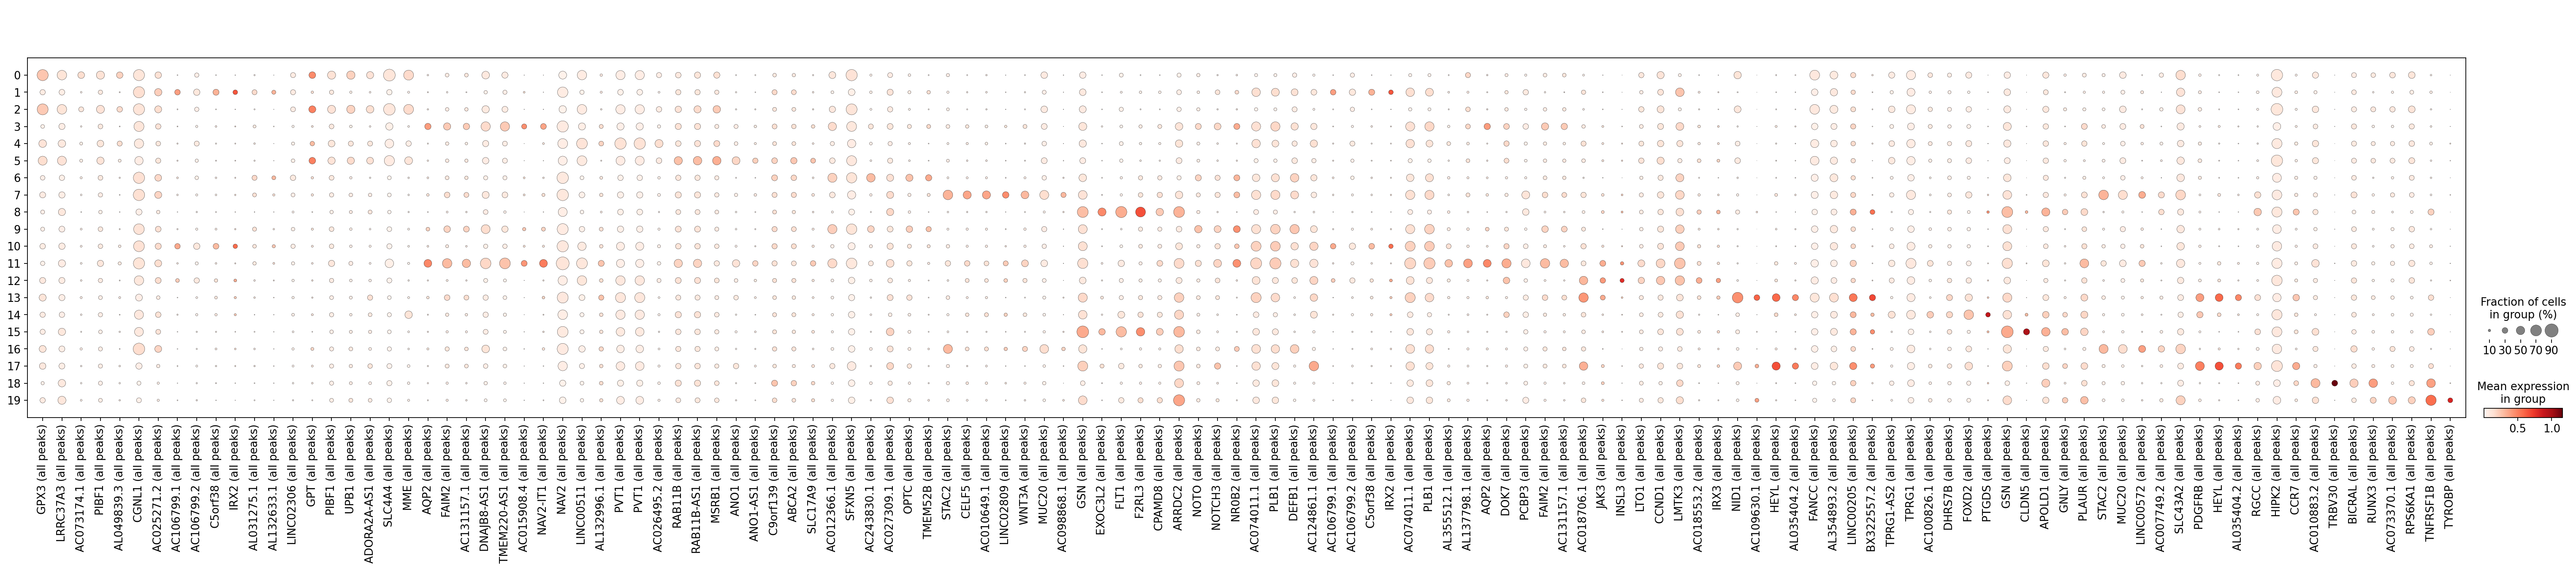

In [37]:
ac.pl.dotplot(atac,genes, groupby='leiden')

In [38]:
del atac.uns['atac']
del atac.uns['files']

In [39]:
atac

AnnData object with n_obs × n_vars = 75013 × 152291
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nucleosome_signal', 'tss_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors', 'lsi', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_lsi', 'X_umap', 'X_lsi_harmonized'
    varm: 'LSI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
atac.write(f'objects/atac_clusters.h5ad', compression = 'gzip')